# Введение

**Основные задачи, решаемые в страховании**
* Классические задачи:
    * тарификация
    * антифрод
    * расчет комиссии посредников
* ML дало развитие задачам:
    * скоринг клиентов
    * оценка риска
    * оценка ущерба (резерва)
    * вероятность пролонгации
    * вероятность покупки опций
    * вероятность кросс-продаж
    * оценка параметров, неизвестных на начальном этапе (например, балл БКИ на предварительном расчете)
    * варианты развития убытка (вероятность отказа в выплате, вероятность суда, мошенничества)
    * распознавание марок-моделей ТС по фото
    * распознавание повреждений ТС по фото

**Риски, оцениваемые в автостраховании**
* Повреждения кузова
  * наш клиент виновен / невиновен
  * крупные / мелкие убытки
* Ущерб здоровью и жизни
* Обязательная гражданская ответственность (ОСАГО)
* Добровольная гражданская ответственность (ДАГО)
* Повреждения в результате действия третьих лиц
* Тоталь
* Угон
* Прочее

**Основная идея метода бустинга**
* Строится модель, прогнозирующая целевую переменную
* Находятся отклонения между прогнозными и фактическими значениями
* Отклонения - новая целевая переменная
* Строится модель, прогнозирующая отклонения
* Находятся новые отклонения после применения двух моделей
* Новые отклонения - снова целевая переменная
* ...

  ![](https://drive.google.com/uc?export=view&id=1S6rBG3Jn0nTww-X_Fs3h00F9OvkXHgUA)

**Особенности бустинга "деревянных" моделей**
* Бόльшая склонность к переобучению, чем у линейных моделей
* Требовательность к подбору гиперпараметров
* Сложность с трактовкой значимости параметров

**Схема решающего дерева для задачи классификации**

  ![](https://drive.google.com/uc?export=view&id=1WlLe4akj2-8LsEeWoS8lCDzATkMKzcO1)



Основная мера неоднородности при построении деревьев - энтропия Шеннона
  ![](https://drive.google.com/uc?export=view&id=16FWKv29X4qFkvi8W0MMN9rkOm4TFByq8) ,
где p - вероятность состояния, i - состояние системы. Чем выше энтропия, тем больше хаоса.

  ![](https://drive.google.com/uc?export=view&id=1Dl9u-uwnpBn6a4ORFBXrXMFMDrbBjLtH)

  ![](https://drive.google.com/uc?export=view&id=1f77y84obWiPmX2W57N5cdm4RlVQCz3wf)

  ![](https://drive.google.com/uc?export=view&id=1amL7hYh0D3LEJQt0Ntr1JdqClEgNDODV)

 Прирост информации (изменение энтропии)
  ![](https://drive.google.com/uc?export=view&id=1LPgPB2aSvvhVYa2qD3Kgy-XTD-2oVx5G)

**Алгоритм построения решающих деревьев**
* Вычисляем энтропию исходного множества
* Если энтропия равна 0, значит все объекты принадлежат к одному классу
* Разбиваем исходное множество на два подмножества, вычисляем изменение энтропии
* Среди всех возможных разбиений выбираем то, у которого изменение энтропии наибольшее
* Повторяем процесс: разбиваем каждое из полученных подмножеств

  ![](https://drive.google.com/uc?export=view&id=1Q-qEQLZ-sjPQrei-EBxpmBS9yfZTKU2o)

**Для задачи регрессии**
* Мера неоднородности - это ошибка на выборке

**Градиентный спуск**
* Поиск минимума ошибки за счет движения в сторону антиградиента

**Что работает лучше, деревья решений или линейные модели?**
* Ответ зависит от ситуации с данными
* В страховых задачах оценки риска преимущество "деревянных" моделей неочевидно

# Решение задачи оценки ожидаемых выплат по полису КАСКО методом градиентного бустинга

# Предобработка данных

In [1]:
# Подключение к Google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# warnings.filterwarnings = 'ignore'

## Специфические преобразования

In [4]:
# PATH = '/content/drive/MyDrive/мои временные ряды/'
PATH = ''

In [5]:
# Загрузим набор данных

df = pd.read_csv(PATH+'freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [6]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [7]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [8]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaN,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaN,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [9]:
df.columns

Index(['Exposure', 'LicAge', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat',
       'SocioCateg', 'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'ClaimNbResp', 'ClaimNbNonResp',
       'ClaimNbParking', 'ClaimNbFireTheft', 'ClaimNbWindscreen', 'OutUseNb',
       'RiskArea'],
      dtype='object')

In [10]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [11]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


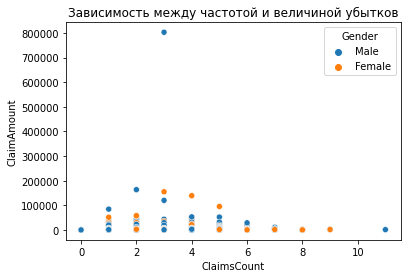

In [12]:
sns.scatterplot( x = df['ClaimsCount'],y = df['ClaimAmount'], hue = df.Gender)
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [13]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

## Общие преобразования

Класс для общих случаев

In [14]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [15]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

Подгружаем данные

In [16]:
data = InsDataFrame_Fr()

In [17]:
data.load_pd(df)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


Преобразовываем параметры

In [19]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [20]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [21]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

Для переменных, содержащих более 2 значений:
- либо упорядочиваем значения,
- либо используем фиктивные переменные (one-hot encoding).

In [22]:
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [24]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [25]:
col_features1 = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
    
]

In [26]:
col_features=col_features1

In [27]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [28]:
df_freq = data.get_pd(col_features+col_target)

In [29]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# import sklearn

In [32]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df_freq[col_features], df_freq.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [33]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df_ac[col_features], df_ac.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

# Градиентный бустинг

Градиентный бустинг - ансамблевый метод машинного обучения, использующийся для задач классификации, регрессии и ранжирования. Ансамбль представляет собой композицию простых базовых алгоритмов, в качестве которых обычно используются деревья решений. 

Классический алгоритм GBM был предложен [Джеромом Фридманом в
1999 году](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). Популярность методов GBM пришла в 2015-2016 гг. благодаря большому
успеху библиотеки XGBoost в соревнованиях Kaggle.

Популярные библиотеки для GBM:
* XGBoost (eXtreme Gradient Boosting)
    * скорость, масштабируемость, поддержка распределенных вычислений
    * добавление компоненты регуляризации, отсутствовавшей в классическом алгоритме GBM
* LightGBM
    * использование алгоритмов, основанных на гистограммах, которые позволяют сократить время исполнения и потребление памяти в процессе обучения моделей. 
* CatBoost (Categorical Boosting)
    * предназначается для эффективной работы с категориальными признаками

Все перечисленные библиотеки зачастую имеют сравнимый результат.

### Теория (XGBoost)

**Модель**

Пусть $y_i$ – значение переменной, которое необходимо предсказать, $x_i$ – входные данные.

Модель имеет вид
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i),\hspace{10pt} f_k \in \mathcal{F},$$
где $K$ – количество деревьев, $f$ – функция на пространстве $\mathcal{F}$, которое содержит все возможные деревья решений.

**Целевая функция**
$$\text{Obj}(\theta) = L(\theta) + \Omega(\theta),$$
где 
* $\theta$ – параметры модели;
* $L$ – величина потерь на обучающей выборке  (насколько хорошо модель описывает данные?);
* $\Omega$ – компонента, отвечающая за регуляризацию (насколько модель сложная?).

Тогда для представленной модели $\theta = \{f_1,f_2,\cdots,f_K\}$,

$$\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K\Omega(f_k),$$
где $l(y_i, \hat{y}_i)$ – функция потерь.

**Обучение**

Необходимо обучить функции $f_i$, каждая из которых включает структуру дерева и значения листьев.

Обозначим $\hat{y}_i^{(t)}$ предсказанное значение на шаге $t$. Тогда целевая функция имеет вид:
$$\text{Obj} = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i).$$

Обучение деревьев происходит поочередно, начиная с постоянного предсказания:
$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

На каждом шаге выбирается дерево, которое оптимизирует целевую функцию.
$$\begin{split}\text{Obj}^{(t)} & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{constant}\end{split}$$


Для упрощения задачи оптимизации для заданной функции потерь используется разложение Тейлора:
$$F(x+\Delta x) \simeq F(x) + F'(x)\Delta x + \frac{1}{2} F''(x)\Delta x^2 + \dots$$

Тогда обозначив градиент и гессиан функции потерь соответственно
$$g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)}),\hspace{10pt}h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)}),$$
целевая функция будет иметь вид
$$\text{Obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}.$$

Убирая константы на шаге $t$, целевая функция упрощается в виде:
$$\text{Obj}^{(t)} = \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t).$$

Таким образом, величина потерь $L$ зависит только от $g_i$ и $h_i$.

Благодаря этому, XGBoost поддерживает пользовательские целевые функции, для которых достаточно задать градиент и гессиан функции потерь.

**Регуляризация**

Для начала определим дерево $f_t(x)$:
$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\},$$
где $w$ – вектор значений на листьях дерева, $T$ – количество листьев, $q$ – функция, которая каждой точке набора данных ставит в соответствие лист дерева.

Тогда сложность модели имеет вид
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2+ \alpha \sum_{j=1}^T |w_j|,$$
где $\gamma$ – штраф на сложность деревьев, $\lambda$ – сила регуляризации $\ell_2$, $\alpha$ – сила регуляризации $\ell_1$.

**Переобучение**
Для контроля переобучения помимо параметров $\gamma$, $\alpha$ и $\lambda$ используются также параметры:
* Контролирующие сложность модели напрямую 
    * максимальная глубина дерева (`max_depth`)
    * минимальный вес в узле, ниже которого прекращается дальнейшее разделение в этом узле (`min_child_weight`)
* Добавляющие случайность, повышая устойчивость к зашумлению
    * $\eta$ – величина шага. $\eta \in (0,1]$.
    Вместо $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ используется 
    $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta\cdot f_t(x_i)$
    * Доля подвыборки наблюдений для построения деревьев (`subsample`)
    * Доля подвыборки признаков для построения деревьев (`colsample_bytree`)

Теория, стоящая за оценкой весов на листьях и нахождением разделений выходит за рамки нашего рассмотрения.

* [Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." ](https://arxiv.org/pdf/1603.02754.pdf)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [А. Дьяконов «Введение в анализ данных и машинное обучение». Градиентный бустинг](https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf)
* [Rokach, Lior. Ensemble Learning: Pattern Classification Using Ensemble Methods (Second Edition)](https://books.google.ru/books/about/Ensemble_Learning_Pattern_Classification.html?id=_AmMDwAAQBAJ&redir_esc=y)

### Выбор гиперпараметров

Основные гиперпараметры, используемые в библиотеке XGBoost
* _objective_ - функция распределения
* _eta_ - размер шага
* _max_depth_ - максимальная глубина дерева
* _min_child_weight_ - минимальный вес, необходимый дочерним элементам
* _subsample_ - доля подвыборки для каждой итерации
* _colsample_bytree_ - доля колонок, участвующих в итерации
* _alpha_ - сила регуляризации L1
* _lambda_ - сила регуляризации L2
* _gamma_ - штраф на сложность деревьев
* _num_boost_round_ - число итераций (фиксируем, не следует менять вместе с _eta_)
* _early_stopping_rounds_ - число итераций для остановки, если не произошло улучшение метрики (фиксируем) 

Стратегии подбора гиперпараметров:
* Поиск на сетке (Grid Search, Randomized Search)
* Покоординатный спуск (Coordinate Descent)
* Генетические алгоритмы (Genetic Algorithms)
* Байесовская оптимизация
* ...

[Использование некоторых алгоритмов подбора гиперпараметров для  XGBoost](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)

Для подбора параметров воспользуемся реализацией алгоритма Tree-structured Parzen Estimator (TPE) в библиотеке `Hyperopt`. Алгоритм использует подход последовательной оптимизации, основанной на модели (sequential model-based optimization, SMBO). Метод основывается в байесовской оптимизации и гауссовских процессах.

* [Bergstra, James S., et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems. 2011.](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [34]:
!pip install hyperopt --upgrade

Requirement already up-to-date: hyperopt in c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages (0.2.5)


In [35]:
!pip install xgboost

In [36]:
from functools import partial
import xgboost as xgb
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

### Построение модели градиентного бустинга для частоты страховых случаев

In [37]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_c = xgb.DMatrix(x_train_c, y_train_c)
valid_c = xgb.DMatrix(x_valid_c, y_valid_c)
test_c = xgb.DMatrix(x_test_c, y_test_c)

In [38]:

# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, y):
    t_hat, t = yhat + 1, y.get_label() + 1
    return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))

In [39]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [40]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_poisson,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [41]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'objective': 'count:poisson',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
           
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

In [42]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_c),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: invalid value encountered in log
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))



  2%|█▎                                                                 | 1/50 [00:02<01:47,  2.19s/trial, best loss=?]

<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))



100%|█████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.28s/trial, best loss: 30057.0371094]


In [43]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.8743047185998503,
 'colsample_bytree': 0.6160894452403542,
 'eta': 0.014803262657123431,
 'lambda': 0.6423256793728933,
 'max_depth': 15,
 'min_child_weight': 3.093851098517125,
 'objective': 'count:poisson',
 'subsample': 0.5594173439601735,
 'tree_method': 'hist'}

In [44]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_poisson,
                'maximize': False,
                'verbose_eval': False}

In [45]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = xgb.train(params=best_params, dtrain=train_c, early_stopping_rounds=10,
                     evals=[(train_c, "train"), (valid_c, "valid")],
                     evals_result=progress, **train_params)

In [46]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_freq_wo_es = xgb.train(params=best_params, dtrain=train_c, evals=[(train_c, "train"), (valid_c, "valid"), (test_c, "test")],
                           evals_result=progress_wo_es, **train_params)

<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: invalid value encountered in log
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))
<ipython-input-38-033a8cc110cf>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))


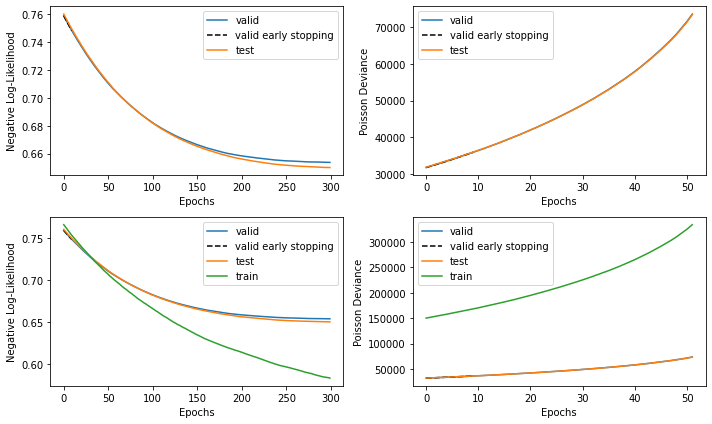

In [47]:
import matplotlib.pyplot as plt
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.plot(progress_wo_es['train']['poisson-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.plot(progress_wo_es['train']['dev_poisson'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout(); plt.show()

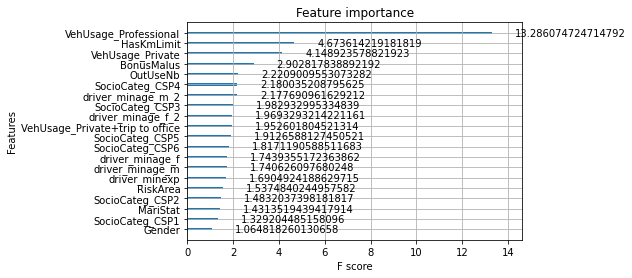

In [48]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[1]); plt.show()

### Построение модели градиентного бустинга для среднего убытка

In [49]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_ac = xgb.DMatrix(x_train_ac, y_train_ac)
valid_ac = xgb.DMatrix(x_valid_ac, y_valid_ac)
test_ac = xgb.DMatrix(x_test_ac, y_test_ac)

In [50]:
# Зададим функцию Deviance для гамма-распределения

def xgb_eval_dev_gamma(yhat, dtrain):
    y = dtrain.get_label()
    return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [51]:
# Определим границы, в которых будем искать гиперпараметры 

space_avgclm = {'objective': 'reg:gamma',
                'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
                'min_child_weight': hp.uniform('min_child_weight', 0, 50),
                'subsample': hp.uniform('subsample', 0.5, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                'alpha': hp.uniform('alpha', 0, 1),
                'lambda': hp.uniform('lambda', 0, 1),
                'eta': hp.uniform('eta', 0.01, 1),
                'tree_method': 'hist'
                }        

In [52]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_gamma,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [53]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_ac),
            space=space_avgclm, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

<ipython-input-50-74abb22e96b7>:5: RuntimeWarning: invalid value encountered in log
  return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)



100%|████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.80trial/s, best loss: 480955.025]


In [54]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_avgclm, best)
best_params

{'alpha': 0.9905566785279389,
 'colsample_bytree': 0.9199222661162403,
 'eta': 0.846988028846706,
 'lambda': 0.9963318246245771,
 'max_depth': 5,
 'min_child_weight': 29.311565818664917,
 'objective': 'reg:gamma',
 'subsample': 0.9985204646507033,
 'tree_method': 'hist'}

In [55]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_gamma,
                'maximize': False,
                'verbose_eval': False}

In [56]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_avgclaim = xgb.train(params=best_params, dtrain=train_ac, early_stopping_rounds=10, evals=[(train_ac, "train"), (valid_ac, "valid")],
                         evals_result=progress, **train_params)

In [57]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_avgclaim_wo_es = xgb.train(params=best_params, dtrain=train_ac, evals=[(train_ac, "train"), (valid_ac, "valid"), (test_ac, "test")],
                               evals_result=progress_wo_es, **train_params)

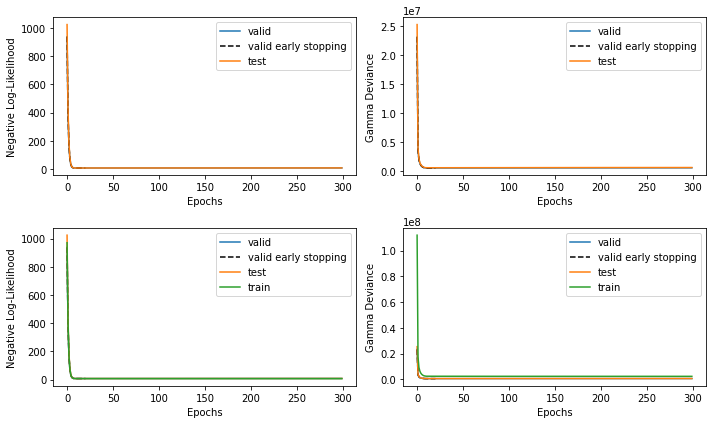

In [58]:
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.plot(progress_wo_es['train']['gamma-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.plot(progress_wo_es['train']['dev_gamma'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout(); plt.show()

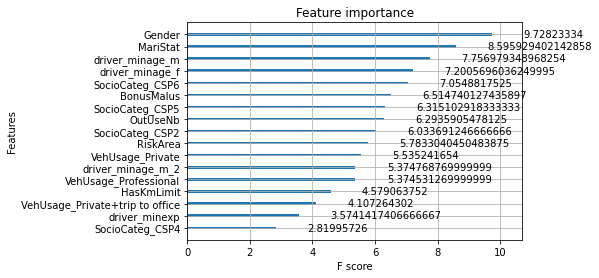

In [59]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_avgclaim, importance_type=importance_type[1]); plt.show()

### Интерпретация моделей градиентного бустинга

* [ELI5 Documentation](https://eli5.readthedocs.io/en/latest/index.html)
* [Константин Лопухин, ELI5: как понять, что выучила ваша ML модель](https://www.youtube.com/watch?v=pqqcUzj3R90)

In [60]:
!pip install eli5

In [61]:
import eli5

c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\ifl\documents\github\ml-in-business\.venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [62]:
eli5.show_weights( xgb_avgclaim, top = 10)

Weight,Feature
0.0948,Gender
0.0837,MariStat
0.0756,driver_minage_m
0.0702,driver_minage_f
0.0687,SocioCateg_CSP6
0.0635,BonusMalus
0.0615,SocioCateg_CSP5
0.0613,OutUseNb
0.0588,SocioCateg_CSP2
0.0563,RiskArea


In [63]:
eli5.explain_prediction(xgb_avgclaim, x_test_ac.iloc[0,:])

Explanation(estimator='<xgboost.core.Booster object at 0x000002B2D2708040>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=7.80379266204737, std=None, value=1.0), FeatureWeight(feature='SocioCateg_CSP5', weight=0.014305567396806225, std=None, value=1.0), FeatureWeight(feature='VehUsage_Private+trip to office', weight=0.009589967463814143, std=None, value=1.0), FeatureWeight(feature='driver_minage_m', weight=0.005263526561230905, std=None, value=18.0), FeatureWeight(feature='SocioCateg_CSP2', weight=0.004953845981525207, std=None, value=0.0), FeatureWeight(feature='OutUseNb', weight=0.0003551534596499912, std=None, value=0.0)], neg=[FeatureWeight(feature='RiskArea', weight=-0.3208155120073174, std=None, value=7.0), FeatureWeight(feature='driver_minage_f', weight=-0.2124219809747557, std=None, value=47.0), FeatureWeight(feature='MariStat', weight=-0.06950040924296359, std=None, value=0.0), FeatureWeight(feature='VehUsage_Private', weight=-0.02115186139086906, std=None, value=0.0), FeatureWeight(feature='BonusMalus', weight=-0.016406018610726977, std=None, value=50.0), FeatureWeight(feature='VehUsage_Professional', weight=-0.009052559455090627, std=None, value=0.0), FeatureWeight(feature='driver_minage_m_2', weight=-0.006113790084113395, std=None, value=324.0), FeatureWeight(feature='driver_minexp', weight=-0.005536800868183211, std=None, value=52.0), FeatureWeight(feature='HasKmLimit', weight=-0.0026122276763787654, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=None, score=7.174649562600002, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

[Interpreting random forests](http://blog.datadive.net/interpreting-random-forests/)

In [64]:
n= 0 
print(xgb_avgclaim.predict(xgb.DMatrix(x_test_ac.iloc[[n],:])), y_test_ac.iloc[[0]].values)
print(np.log(xgb_avgclaim.predict(xgb.DMatrix(x_test_ac.iloc[[n],:]))))

[652.9516] [450.79758308]
[6.481503]


* [Lundberg S. M., Erion G. G., Lee S. I. Consistent individualized feature attribution for tree ensembles](https://arxiv.org/abs/1802.03888)
* [SHAP GitHub](https://github.com/slundberg/shap)
* [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
* https://christophm.github.io/interpretable-ml-book/shap.html

In [65]:
!pip install shap

In [66]:
import shap

In [67]:
explainer = shap.TreeExplainer(xgb_avgclaim)
shap_values = explainer.shap_values(x_test_ac)

In [68]:
shap_values[0,:]

array([-1.1872198e-02, -3.0299525e-03, -2.7634943e-02, -4.3329736e-03,
        1.2069501e-02, -3.8192086e-03, -2.1747465e-01, -9.9344840e-03,
       -3.4410781e-01,  1.3577682e-03,  0.0000000e+00, -1.8219005e-02,
        7.5577162e-03, -1.7428456e-02,  0.0000000e+00,  4.5215120e-03,
        0.0000000e+00, -3.1461025e-04,  3.3588875e-03,  1.5967584e-04],
      dtype=float32)

In [69]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test_ac.iloc[0,:])

In [70]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test_ac)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


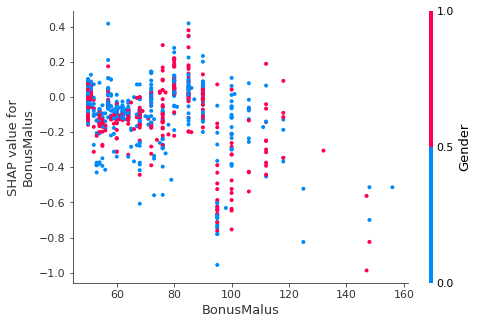

In [71]:
shap.dependence_plot("BonusMalus", shap_values, x_test_ac)

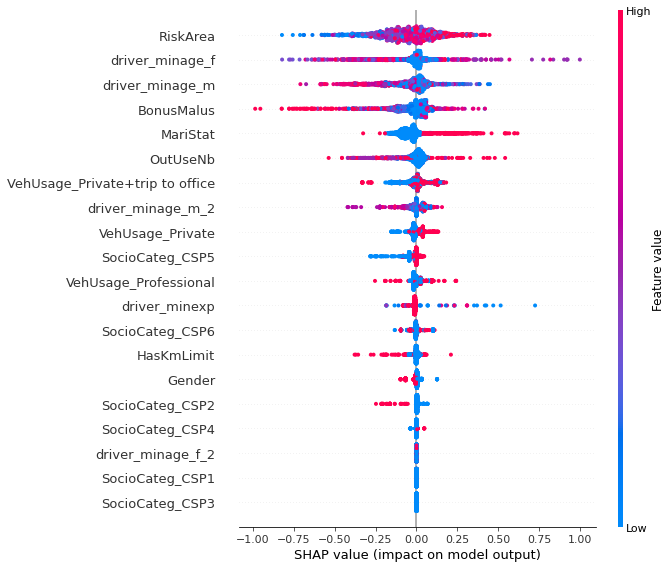

In [72]:
shap.summary_plot(shap_values, x_test_ac)

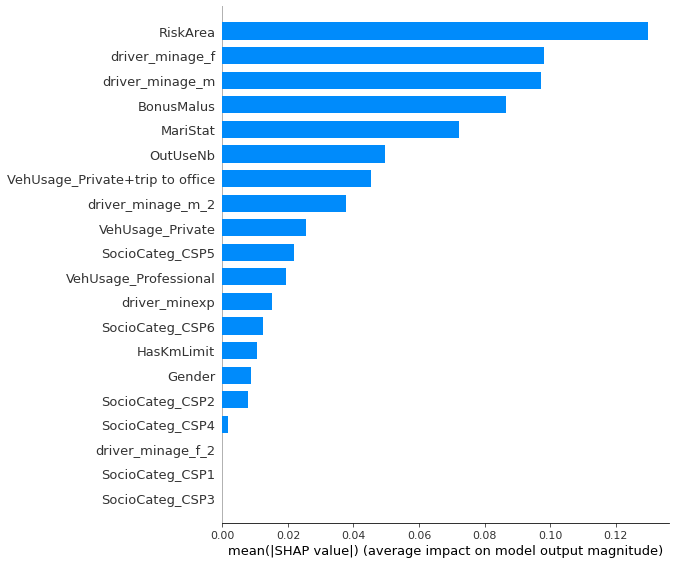

In [73]:
shap.summary_plot(shap_values, x_test_ac, plot_type="bar")

### Использование моделей градиентного бустинга

In [74]:
predictions = pd.DataFrame()
predictions['CountPredicted'] = xgb_freq.predict(xgb.DMatrix(df_freq[col_features]))
predictions['AvgClaimPredicted'] = xgb_avgclaim.predict(xgb.DMatrix(df_freq[col_features]))

In [75]:
predictions['CountPredicted'].min()

0.46684808

In [76]:
predictions['BurningCost'] = predictions.CountPredicted * predictions.AvgClaimPredicted
predictions.head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.482247,1518.369385,732.229736
1,0.482247,1518.369385,732.229736
2,0.480325,827.398560,397.420258
3,0.480187,1083.455444,520.260864
4,0.473728,1381.150146,654.289978


Об особенностях сохранения моделей:

In [77]:
xgb_avgclaim.save_model('avg_claim.model')

In [78]:
xgb_avgclaim.feature_names

['driver_minexp',
 'Gender',
 'MariStat',
 'HasKmLimit',
 'BonusMalus',
 'OutUseNb',
 'RiskArea',
 'driver_minage_m',
 'driver_minage_f',
 'driver_minage_m_2',
 'driver_minage_f_2',
 'VehUsage_Private',
 'VehUsage_Private+trip to office',
 'VehUsage_Professional',
 'SocioCateg_CSP1',
 'SocioCateg_CSP2',
 'SocioCateg_CSP3',
 'SocioCateg_CSP4',
 'SocioCateg_CSP5',
 'SocioCateg_CSP6']

In [79]:
xgb_avgclaim.feature_types

['int',
 'int',
 'int',
 'int',
 'int',
 'float',
 'float',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int']

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [80]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin

In [81]:
df = pd.read_csv(PATH+'freMPL-R.csv', low_memory=False)

In [82]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [83]:
#delete negative ClaimAmount
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [84]:
df.columns

Index(['Exposure', 'LicAge', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat',
       'SocioCateg', 'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'ClaimNbResp', 'ClaimNbNonResp',
       'ClaimNbParking', 'ClaimNbFireTheft', 'ClaimNbWindscreen', 'OutUseNb',
       'RiskArea'],
      dtype='object')

In [88]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [89]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


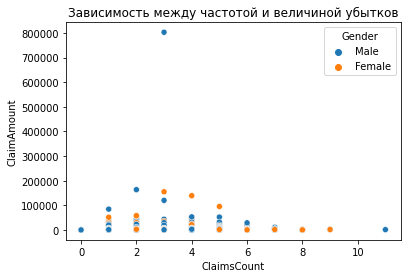

In [90]:
sns.scatterplot( x = df['ClaimsCount'],y = df['ClaimAmount'], hue = df.Gender)
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

In [91]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


In [94]:
data = InsDataFrame_Fr()
data.load_pd(df)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


In [95]:
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')
data.get_dummies(['VehUsage','SocioCateg'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [100]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [103]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [110]:
df_freq = data.get_pd(col_features+col_target)
df_freq

,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,driver_minage_m_2,...,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,ClaimAmount,ClaimsCount,AvgClaim
0,52,0,0,0,50,0.0,9.0,46,18,2116,...,0,0,0,0,1,0,0,0.000000,0.0,NaN
1,52,0,0,0,50,0.0,9.0,46,18,2116,...,0,0,0,0,1,0,0,0.000000,0.0,NaN
2,52,0,0,0,68,0.0,7.0,32,18,1024,...,0,0,0,0,1,0,0,0.000000,0.0,NaN
3,52,1,0,0,50,0.0,8.0,18,52,324,...,0,0,0,0,1,0,0,0.000000,0.0,NaN
4,52,0,0,0,50,0.0,7.0,57,18,3249,...,0,0,0,0,0,1,0,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,52,0,0,0,50,4.0,8.0,39,18,1521,...,0,0,0,0,1,0,0,0.000000,0.0,NaN
115151,52,1,0,0,50,0.0,7.0,18,54,324,...,0,0,0,0,1,0,0,2764.169184,2.0,1382.084592
115152,52,0,0,0,54,0.0,7.0,35,18,1225,...,0,0,0,0,1,0,0,0.000000,0.0,NaN
115153,52,0,0,0,50,0.0,7.0,52,18,2704,...,0,0,0,0,1,0,0,0.000000,0.0,NaN


In [112]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()
df_ac

,index,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,...,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,ClaimAmount,ClaimsCount,AvgClaim
0,33,52,0,0,0,50,0.0,4.0,68,18,...,0,0,0,0,0,1,0,5377.204532,4.0,1344.301133
1,34,52,1,1,0,50,0.0,6.0,18,47,...,0,0,0,0,1,0,0,2017.843505,2.0,1008.921752
2,53,52,0,0,0,50,2.0,8.0,49,18,...,0,0,0,0,1,0,0,356.773414,2.0,178.386707
3,65,52,0,0,0,50,0.0,9.0,70,18,...,0,0,0,0,0,1,0,645.125982,1.0,645.125982
4,66,52,1,0,0,54,0.0,8.0,18,49,...,0,0,0,0,1,0,0,1200.422356,2.0,600.211178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10864,115085,52,0,0,1,50,0.0,9.0,70,18,...,0,0,0,0,0,1,0,230.736254,2.0,115.368127
10865,115138,52,1,0,1,62,0.0,7.0,18,69,...,0,0,0,0,1,0,0,1562.356495,3.0,520.785498
10866,115142,52,0,0,0,50,0.0,6.0,63,18,...,0,0,0,0,0,1,0,476.318429,3.0,158.772810
10867,115148,52,0,0,0,50,0.0,7.0,53,18,...,0,0,0,0,1,0,0,1117.886103,1.0,1117.886103


XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [123]:
df_ac.loc[df_ac.ClaimsCount == 11, 'ClaimsCount'] = 10

In [129]:
df_ac[df_ac['ClaimsCount'] == 11]

,index,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,...,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,ClaimAmount,ClaimsCount,AvgClaim


Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [135]:
FreqCount = pd.DataFrame(df_ac, columns=['ClaimsCount'])
# FreqCount['Freq'] = FreqCount.ClaimsCount / FreqCount.groupby(['ClaimsCount']).mean()
FreqCount

,ClaimsCount
0,4.0
1,2.0
2,2.0
3,1.0
4,2.0
...,...
10864,2.0
10865,3.0
10866,3.0
10867,1.0


In [146]:
pol = pd.DataFrame(FreqCount.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)
pol

,Policies
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2
10.0,1


In [152]:
pol_count = pol.Policies.sum()
pol_count

10869

In [154]:
FreqCount['ClaimsCount']

0        4.0
1        2.0
2        2.0
3        1.0
4        2.0
        ... 
10864    2.0
10865    3.0
10866    3.0
10867    1.0
10868    2.0
Name: ClaimsCount, Length: 10869, dtype: float64

In [158]:
FreqCount[pol.index == FreqCount['ClaimsCount']]

ValueError: Lengths must match to compare

In [151]:
FreqCount['Freq'] = pol[FreqCount['ClaimsCount']] / pol_count

KeyError: "None of [Float64Index([4.0, 2.0, 2.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 2.0,\n              ...\n              3.0, 1.0, 2.0, 4.0, 3.0, 2.0, 3.0, 3.0, 1.0, 2.0],\n             dtype='float64', length=10869)] are in the [columns]"

In [142]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Freq'

In [143]:
FreqCount

,ClaimsCount
0,4.0
1,2.0
2,2.0
3,1.0
4,2.0
...,...
10864,2.0
10865,3.0
10866,3.0
10867,1.0


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [ ]:
df['weight'] = '<Ваш код здесь>'

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split('<Ваш код здесь>')
x_valid, x_test, y_valid, y_test = train_test_split('<Ваш код здесь>')

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [ ]:
xgb_train = '<Ваш код здесь>'
xgb_valid = '<Ваш код здесь>'
xgb_test = '<Ваш код здесь>'

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [ ]:
'<Ваш код здесь>'

Далее обучим нашу модель с оптимальными параметрами

In [ ]:
'<Ваш код здесь>'

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [ ]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = '<Ваш код здесь>' # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score('<Ваш код здесь>', average='micro')) # Посчитаем F1 Score

In [ ]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?